In [5]:
import pandas as pd
import numpy as np
from pandas import read_csv
import csv
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn import manifold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR, SVC
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from scipy.spatial.distance import cdist
from sklearn.preprocessing import Imputer
from fancyimpute import SoftImpute
from sklearn.metrics import roc_curve, auc, silhouette_score
from sklearn.metrics import roc_auc_score
import re
from scipy import stats
import glmnet_python
from glmnet import glmnet; from glmnetPlot import glmnetPlot 
from glmnetPrint import glmnetPrint; from glmnetCoef import glmnetCoef; from glmnetPredict import glmnetPredict
from cvglmnet import cvglmnet; from cvglmnetCoef import cvglmnetCoef
from cvglmnetPlot import cvglmnetPlot; from cvglmnetPredict import cvglmnetPredict
import math
import statsmodels.api as sm

/home/ananth/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Predict Output Variables

This file predicts output variables using regression and classification models. Both regression are classification are applied to full dataset and clusters.

Select input and output variables in the first section and then run functions at the bottom of the notebook.

# Select Inputs and Outputs

#### We only use one output at a time. Here are the list of outputs to plug into the output variable below:

* asset_owned___output
* crop_diversification___output
* crop_sales___output
* crop_sales_specialization___output
* expenditure___output
* food_expenditure_diversification___output
* income___output
* income_diversification___output

# Main Function

In [156]:
def get_classes(output_var, pred):
    max_bins = 3
    _, boundaries = np.histogram(output_var, bins=max_bins)
    classes = np.digitize(pred, bins=boundaries)
    return classes, max_bins

def for_year(var, year):
    return var + '___ethiopia_' + str(year)

colors= {2011:'r', 2013:'g', 2015:'blue'}
ax = {}
def run_regressions(in_name, out_dir, non_policy_inputs, segment_variables, inputs, output, year):
    global table
    global coef_table
    global avg_table
    global coef_map
    # table for regressions and classification
    table = pd.DataFrame()
    avg_table = pd.DataFrame()
    coef_map = {}
    # create table of coefficients
    coef_table = pd.DataFrame()
    
    try:
        os.mkdir(out_dir)
    except:
        print("Dir exists")
    
    ols = linear_model.LinearRegression()
    ridge = linear_model.Ridge(alpha=.5)
    lasso = linear_model.Lasso(alpha = 0.01, max_iter=1e5)
    lars_lasso = linear_model.LassoLars(alpha=.1)
    bayes_ridge = linear_model.BayesianRidge()
    sgd = linear_model.SGDRegressor()
    svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
    svr_lin = SVR(kernel='linear', C=1e3)
    svr_poly = SVR(kernel='poly', C=1e3, degree=2)
    kernel_ridge = KernelRidge(alpha=1.0)
    
    # pick which regression algos to use
    regression_algorithms = (
#        ('OrdinaryLeastSquares', ols),
#        ('RidgeRegression', ridge),
        ('Lasso', lasso),
#         ('LARS Lasso', lars_lasso),
#         ('BayesianRidgeRegression', bayes_ridge),
#         ('StochasticGradientDescent', sgd),
#         ('SupportVectorRegressionRBF', svr_rbf),
#         ('SupportVectorRegressionLinear', svr_lin),
#         ('SupportVectorRegressionPolynomial', svr_poly),
#         ('KernelRidgeRegression', kernel_ridge)
    )
    
    df = read_csv(in_name)
    raw_df = read_csv(in_name.replace('normed', 'raw'))
#     df[output] = raw_df[for_year('crop_sales___output', year)]/raw_df[for_year('land_surface', year)]*10000.0
    df = df.loc[df[output].dropna().index] # drop rows with unobserved income
#     df = df.loc[df['household_head_is_male___ethiopia_2015']==0]
    df['nid']= df.index.tolist()
#     filter_var = 'lives_in_amhara___ethiopia_' + str(year)
#     df = df[df[filter_var]==True]
    #df = df.loc[df[output] != 0] # drop zero outputs
    # select % of data in test set
    test_split = 0.2
    
    # perform matrix completion. completed is returned as a np array
    # we've discussed not using it, but I left it in because I wasn't able to
    # fit the StandardScaler with a DataFrame that contained NaN's

    imp = Imputer(strategy="mean")
    completed = imp.fit_transform(df)

    # if we want to use low rank matrix completion inst
    # completed = SoftImpute().complete(x)
    
    # reconstruct dataframe with completed matrix
    cols = df.columns.values
    mat = pd.DataFrame(completed,columns=cols)
    
#     raw_df[output] = raw_df[for_year('crop_sales___output', year)]/raw_df[for_year('land_surface', year)]*10000.0
    raw_df = raw_df.loc[df[output].dropna().index]
#     raw_df = raw_df.loc[raw_df['household_head_is_male___ethiopia_2015']==0]
    raw_df['nid']= raw_df.index.tolist()
    raw_imp = Imputer(strategy="mean")
    raw_completed = raw_imp.fit_transform(raw_df)
    raw_cols = raw_df.columns.values
    raw_df = pd.DataFrame(raw_completed,columns=raw_cols)
    raw_df['productivity'] = raw_df[for_year('crop_sales___output', 2015)]/raw_df[for_year('land_surface', 2015)]
    raw_df['productivity'] = raw_df['productivity'].apply(lambda x: 0 if x == np.inf else x)

#     raw_df[output] = raw_df[output].apply(lambda x: 100.0*math.exp(x))
    #relevant_vars = ['hired_labor___policy', 'oxen_owned___policy', 'chemical_fertilizers_used___policy', 'land_surface', 'plough_owned___policy']
#     relevant_vars = list(segment_variables.keys())
#     for seg_var in relevant_vars:
# #         seg_var_year = for_year(seg_var, year)
#         seg_var_year = seg_var
#         raw_df[seg_var_year] = raw_df[seg_var_year].apply(lambda x: math.exp(x) - 1)
#     weight_cols = filter(lambda x: x.find('weight') != -1, mat.columns)
#     for col in cols:
#         if col in weight_cols:
#             continue
#         mat[col] = mat[col] * mat[for_year('weight', year)]
#     mat[output] = mat[output] * raw_df[for_year('weight', year)]
    
    mat_scaled = StandardScaler()
    mat_scaled.fit(mat)
    mat_sc = mat_scaled.transform(mat)
    mat = pd.DataFrame(mat_sc, columns=mat.columns)
    mat[for_year('animals___policy', year)] = mat[for_year('number_of_oxen_owned___policy', year)] + mat[for_year('number_of_plough_owned___policy', year)] + mat[for_year('number_of_axe_owned___policy', year)] + mat[for_year('number_of_pick_axe_owned___policy', year)] + mat[for_year('number_of_sickle_owned___policy', year)]
    mat[for_year('tools___policy', year)] = mat[for_year('number_of_axe_owned___policy', year)] + mat[for_year('number_of_pick_axe_owned___policy', year)] + mat[for_year('number_of_sickle_owned___policy', year)]
    inputs += [for_year('animals___policy', year), for_year('tools___policy', year)]
    #     mat = mat.drop(weight_cols, axis=1)
    #scale_up_factor = 100.0
    #mat[output] = mat[output].apply(lambda x: x*scale_up_factor)
    y = mat[output]
    x = mat[inputs]
    
    def update_best_lambda(x_scaled):
        global regression_algorithms
        copy_y = np.array(y, dtype=np.float64)
        print (copy_y)
        fit = cvglmnet(x = x_scaled.copy(), y = copy_y)
        print ('Best alpha={0}'.format(fit['lambda_min']))
        regression_algorithms = (('Lasso', linear_model.Lasso(alpha=fit['lambda_min'], max_iter=1e5)))
        return fit['lambda_min']
    
    # Split test/train
    indices = range(len(mat))
    x_train, x_test, y_train, y_test, ind_train, ind_test = \
        train_test_split(x, y, indices, test_size=test_split, random_state=42)
    
    def get_train_test(input_vars):
        x = mat[input_vars].copy()
#         for col in x.columns.values:
#             x[col] = x[col] * raw_df[for_year('weight', year)]
        x_scaled = StandardScaler()
        x_scaled.fit(x)
        x_sc = x_scaled.transform(x)
        # reconstruct DataFrame
        x = pd.DataFrame(x_sc, columns=x.columns)
        training_x = x.iloc[ind_train, :]
        testing_x = x.iloc[ind_test, :]
        return x_sc, training_x, testing_x
    
    def digitize(output_var, pred):
        from sklearn.preprocessing import label_binarize
        classes, max_bins = get_classes(output_var, pred)
        b_classes = label_binarize(classes, range(max_bins))
        return b_classes
    
    def calc_unsegmented(baseline, x_train, x_test): 
        global table
        global coef_map
        # reg keeps predictions from regressions along with keys
        reg = dict()
        for name, algo in regression_algorithms:
            reg[name] = {}

        # keys and values from test data
        keys_list = []
        y_list = []
        for k, v in y_test.iteritems():
            keys_list.append(k)
            y_list.append(v)

        # run regressions on full dataset
        for name, algo in regression_algorithms:
            ### CI calculation
            model = sm.OLS(y_train, x_train)
#             fit = model.fit_regularized(alpha=0.006, refit=True)
            fit = model.fit()
            print("Confidence intervals are {0}".format(fit.conf_int()))
            y_pred = fit.predict(x_test)
            
#             model = algo.fit(x_train,y_train)
#             y_pred = model.predict(x_test)

            # add predictions to dict
            for i, p in enumerate(y_pred):
                t = reg[name]
                t[keys_list[i]] = p

            try:
                test_c = digitize(y, y_test)
                pred_c = digitize(y, y_pred)
                auc_c = roc_auc_score(test_c, pred_c, average='macro')
            except ValueError:
                auc_c = 0.5
            mse = mean_squared_error(y_test,y_pred)
            scaled_mse = (mse/np.std(y))

            # add row to table
            new_row = pd.DataFrame({'model': name, 'segment': '', 'input': baseline, 'scaled_mse': scaled_mse, 'mse': mse, 'roc_auc': auc_c, 'clustered': False}, index=[0])
            table = table.append(new_row, ignore_index=True)

            # add coefficients to map
#             coef_map[name + '_' + baseline] = model.coef_
            coef_map[name + '_' + baseline] = fit.params
            lower_bounds = []
            upper_bounds = []
            ci = fit.conf_int()
            for ci_row in ci.iterrows():
                lower_bounds += [ci_row[1][0]]
                upper_bounds += [ci_row[1][1]]
#             for ci in fit.conf_int():
#                 lower_bounds += [ci[0]]
#                 upper_bounds += [ci[1]]
            coef_map[name + '_' + baseline + '_lower_bound'] = lower_bounds
            coef_map[name + '_' + baseline + '_upper_bound'] = upper_bounds
    
    def calc_segmented(segment_variables, baseline, x_train, x_test):
        global table
        global coef_map
        global avg_table
#         segment_vars = segment_variables
        segment_vars = list(segment_variables.keys())
        def iterative_clustering(sc_thres, corr_thres, alpha):
            max_sc = 0
            best_kmeans = None
            
#                 alpha = (1+a)/10.0
            sc_incr = 1e-8
            sc_thres = -1e-1
            C = set([])
            avail = set(segment_variables.keys())
            prev_sc = 0
            min_k = 4
            corr_thres = 0.05
            while sc_incr >= sc_thres:
                u_f = 0
                best_f = None
                sc_best = 0
                for f in avail:
                    if segment_variables[f] < corr_thres:
                        continue
                    seg_data = mat[list(avail) + [f]]
                    kmeans = KMeans(n_clusters=min_k).fit(seg_data)
                    labels = kmeans.labels_
                    sc = silhouette_score(seg_data, labels)
                    sc_delta = sc - prev_sc
                    if u_f < (segment_variables[f] + (alpha)*sc_delta):
                        u_f = (segment_variables[f] + (alpha)*sc_delta)
                        best_f = f
                        sc_best = sc
                if best_f == None:
                    break
                avail.remove(best_f)
                C.add(best_f)
#                 print (alpha, best_f, u_f, sc, prev_sc)
                sc_incr = sc - prev_sc
                prev_sc = sc
            
            seg_data = mat[list(C)]
            kmeans = KMeans(n_clusters=min_k).fit(seg_data)
            labels = kmeans.labels_
            sc = silhouette_score(seg_data, labels)
            return sc, kmeans

        
        def add_clusters():
#             from scipy.spatial import Voronoi, voronoi_plot_2d
            # elbow method
            sse = []
        
                
#             #### Multiply by correlation coefficient
            seg_data = mat[segment_vars]
            for seg_var in segment_vars:
#                 seg_data[seg_var] = seg_data[seg_var]*mat[for_year('weight', year)]
                seg_data[seg_var] = seg_data[seg_var].apply(lambda x: x*segment_variables[seg_var])
    
            ### Plot elbow
#             for k in range(1,9):
#                 kmeans = KMeans(n_clusters=k).fit(seg_data)
#                 labels = kmeans.labels_
#                 sse.append(sum(np.min(cdist(seg_data, kmeans.cluster_centers_, 'euclidean'), axis=1)) / seg_data.shape[0])

#             plt.clf()
#             plt.plot(range(1,9), sse)
#             plt.xlabel('k')
#             plt.ylabel('Sum of squared error')
#             plt.savefig(os.path.join(out_dir, 'elbow.png'))
#             print(sse)
#             min_k = sse.index(min(sse))
#             print (min_k)

            ### Iterative clustering
#             max_sc = -1
#             best_kmeans = None
#             for sc_thres in [-0.1, -0.05, -0.01, -0.001, -1e-3, 0, 1e-3, 1e-2]:
#                 for corr_thres in [0.05, 0.06, 0.08, 0.1, 0.12, 0.15]:
#                     for alpha in [1e-4,1e-3,1e-2,0.1,1,10,100,1000,10000]:
#                         sc, kmeans = iterative_clustering(sc_thres, corr_thres, alpha)
#                         if sc > max_sc:
#                             max_sc = sc
#                             best_kmeans = kmeans
#                             print ('Best found: {0}, {1}, {2}'.format(sc_thres, corr_thres, alpha))
            
#             kmeans = best_kmeans
    
            min_k = 4
            kmeans = KMeans(n_clusters=min_k).fit(seg_data)
            labels = kmeans.labels_
            mat['cluster'] = labels
            means = []
            for i in np.unique(labels):
                sel_mat = mat[mat['cluster'] == i]
                raw_clus = raw_df.loc[sel_mat.index]
                values = raw_clus[output].as_matrix()
                weights = raw_clus[for_year('weight', year)].as_matrix()
                average = np.average(values, weights=weights)
                means.append(average)
            sorted_ids = [i[0] for i in sorted(enumerate(means), key=lambda x:x[1])]
            print(sorted_ids)
            mat['cluster'] = mat['cluster'].apply(lambda x: sorted_ids.index(x))
#             vor = Voronoi(seg_data)
#             plt.clf()
#             voronoi_plot_2d(vor)
#             plt.savefig(os.path.join(out_dir, 'voronoi.pdf'))
            #mat['cluster_'+str(year)] = labels
            select_variables = [output, 'latitude___ethiopia_2015', 'longitude___ethiopia_2015', 'nid'] + segment_vars
            select_variables = [t.replace('norm', 'raw') for t in select_variables]

#             id_df = pd.DataFrame(df.index.tolist())
#             sel_df = pd.concat([, id_df], axis=0)
            all_output = pd.concat([mat['cluster'], raw_df[list(select_variables)]], 1)
            all_output.to_csv(os.path.join(out_dir,'clus_' + baseline + '_' + output + '.csv'))
            return min_k
            
        
        # Add segments
        def add_segments():
            median_segments = {}
            for seg_var in segment_vars:
                #binary
                if len(np.unique(mat[seg_var])) <= 3:
                    median_segments[seg_var] = 0
                else:
                    median_segments[seg_var] = np.median(mat[seg_var])
            mat['cluster'] = 0
            for seg_var in segment_vars:
                mat['cluster'] = 2*mat['cluster'] + [int(x) for x in mat[seg_var] > median_segments[seg_var]]
            #mat[['cluster'] + segment_vars].to_csv(os.path.join(out_dir,'segment_' + ','.join(segment_vars) + '_' + baseline + '_' + output + '.csv'))
            return int(math.pow(2, len(segment_vars)))

        def add_location_segments():
            locations = ['afar', 'amhara', 'benishangul_gumuz', 'dire_dawa', 'gambella', 'harari', 'oromiya', 'snnp', 'somalie', 'tigray']
            i = 0
            mat['cluster'] = 0
            for l in sorted(locations):
                loc_feature = 'lives_in_' + l + '___ethiopia_' + str(year)
                loc_val = mat[loc_feature].apply(lambda x: 0 if x < 0 else 1)
                mat['cluster'] = mat['cluster'] + (i*loc_val)
                i += 1
            return len(locations) + 1
            
        def _run(max_clusters, method_name):
            global table
            global avg_table
            global coef_map
            # reg_clus keeps predictions from clustered regressions along with keys
            reg_clus = dict()

            for name, algo in regression_algorithms:
                reg_clus[name] = {}

            # need new dataframes with only training and test rows.
            # we use this when looping through clusters
            train_mat = mat.loc[ind_train]
            test_mat = mat.loc[ind_test]
            train_size = len(train_mat)
            # same code as regular regressions, but add loop for clusters
            series = {}
            series[output] = []
            for seg in segment_vars:
                series[seg] = []
            series = pd.DataFrame()
            row = {}
            raw_cols = raw_df.columns.values
            raw_reg = re.compile('^((?!norm).)*2015$')
            avg_variables = list(filter(raw_reg.search, raw_cols))
#             for seg in segment_vars:
#                 values = raw_df[seg].as_matrix()
#                 weights = raw_df[for_year('weight', year)].as_matrix()
#                 average = np.average(values, weights=weights)
#                 row['weighted_mean_' + seg] = average
#                 row['normal_mean_' + seg] = np.mean(values)
#             new_row = pd.DataFrame(row, index=[0])
#             avg_table = avg_table.append(new_row, ignore_index=True)
#             avg_table = avg_table.transpose()
            for i in range(max_clusters):
                train_clus = x_train.loc[train_mat['cluster'] == i]
                train_y = y_train.loc[train_mat['cluster'] == i]
                test_clus = x_test.loc[test_mat['cluster'] == i]
                test_y = y_test.loc[test_mat['cluster'] == i]
                sel_mat = mat[mat['cluster'] == i]
                raw_clus = raw_df.loc[sel_mat.index]
#                 avg_variables = segment_vars
#                 avg_variables = [
#                     'use_extension_program___policy',
#                     'prevent_damage___policy',
#                     'hired_labor___policy', 
#                     'oxen_owned___policy', 
#                     'chemical_fertilizers_used___policy', 
#                     'land_surface',
#                     'plough_owned___policy',
#                     'household_size',
#                 ]
#                 avg_variables = [for_year(x, year) for x in avg_variables]
                for seg in avg_variables:
                    values = raw_clus[seg].as_matrix()
                    weights = raw_clus[for_year('weight', year)].as_matrix()
                    average = np.average(values, weights=weights)
                    row['mean_' + seg] = average
                    row['avg_' + seg] = np.mean(values)
                    variance = np.average((values-average)**2, weights=weights)
                    row['stddev_' + seg] = math.sqrt(variance)
                    row['stderr_' + seg] = math.sqrt(variance)/math.sqrt(len(values))
                    row['25ile_' + seg] = np.percentile(values, 25)
                    row['75ile_' + seg] = np.percentile(values, 75)
#                     row['mean_' + seg] = np.mean(pd.concat([raw_clus[seg], test_clus[seg]], 0).as_matrix())
#                 row['segment'] = ','.join(segment_vars)
                row['index'] = i
#                 row['mean_output'] = np.mean(raw_clus[output.replace('norm', 'raw')].as_matrix())
#                 row['stddev_output'] = np.std(raw_clus[output.replace('norm', 'raw')].as_matrix())
                row['size'] = len(raw_clus)
                new_row = pd.DataFrame(row, index=[0])
                series = series.append(new_row, ignore_index=True)
                avg_table = avg_table.append(new_row, ignore_index=True)
                cluster_percent = (len(train_clus)*100.0)/train_size
                if train_clus.empty or test_clus.empty: # or cluster_percent < 5:
                    continue

                keys_list = []
                y_list = []
                for k, v in test_y.iteritems():
                    keys_list.append(k)
                    y_list.append(v)

                for name, algo in regression_algorithms:  
#                     model = algo.fit(train_clus,train_y)
#                     y_pred = model.predict(test_clus)
                    
                    model = sm.OLS(train_y, train_clus)
#                     fit = model.fit_regularized(alpha=0.00617565, refit=True)
                    fit = model.fit()
                    print("Confidence intervals are {0}".format(fit.conf_int()))
                    y_pred = fit.predict(test_clus)

                    for a, b in enumerate(y_pred):
                        t = reg_clus[name]
                        t[keys_list[a]] = b

                    coef_map[name + '_' + method_name + '_' + ','.join(segment_vars) + '_' + str(i)] = fit.params
                    lower_bounds = []
                    upper_bounds = []
                    ### CI for ols
                    ci = fit.conf_int()
                    for ci_row in ci.iterrows():
                        lower_bounds += [ci_row[1][0]]
                        upper_bounds += [ci_row[1][1]]

                    ### CI for Lasso
#                     for ci in fit.conf_int():
#                         lower_bounds += [ci[0]]
#                         upper_bounds += [ci[1]]

                    coef_map[name + '_' + method_name + '_' + str(i) + '_lower_bound'] = lower_bounds
                    coef_map[name + '_' + method_name + '_' + str(i) + '_upper_bound'] = upper_bounds

#                     coef_map[name + '_' + method_name + '_' + ','.join(segment_vars) + '_' + str(i)] = model.coef_

            # plot sorted correlation
            sorted_series = series.sort_values(['mean_' + output])
#             prev = None
#             min_diff = math.inf
#             for mean_out in sorted_series['mean_output'].as_matrix():
#                 if prev == None:
#                     prev = mean_out
#                     continue
#                 diff = mean_out - prev
#                 min_diff = min(min_diff, diff)
            
            
            raw_segment_vars = avg_variables
#             [t.replace('norm', 'raw') for t in segment_vars] + [
#                 'gender_equity___ethiopia_2015', 
#                 'has_saved___policy___ethiopia_2015',
#             ]
            for seg in raw_segment_vars:
                plt.clf()
                plt.plot(sorted_series['mean_' + output].as_matrix(), sorted_series['mean_'+seg].as_matrix(), marker='o')
                plt.xlabel('Average ' + output.replace('___output___ethiopia_2015', '') + ' output')
                plt.ylabel('Average ' + seg.replace('___policy___ethiopia_' +str(year), '').replace('_',' '))
                plt.savefig(os.path.join(out_dir, 'plot_' + seg + '_' + output + '.pdf'))
                
            # add mse's to table
            keys = sorted(y_test.keys())
            for name, algo in regression_algorithms:
                sort_t = []
                sort_p = []

                for key in keys:
                    if key not in y_test or key not in reg_clus[name]:
                        continue
                    sort_t.append(reg_clus[name][key])
                    sort_p.append(y_test[key])

                try:
                    test_c = digitize(y, sort_t)
                    pred_c = digitize(y, sort_p)
                    auc_c = roc_auc_score(test_c, pred_c, average='macro')
                except ValueError:
                    auc_c = 0.5
                mse = mean_squared_error(sort_t,sort_p)
                scaled_mse = (mse/np.std(y))
                new_row = pd.DataFrame({'model': name, 'segment': ','.join(segment_vars), 'input': baseline, 'scaled_mse': scaled_mse, 'mse': mse, 'roc_auc': auc_c, 'clustered': True, 'method': method_name}, index=[0])
                table = table.append(new_row, ignore_index=True)
                
    
        ##### Run grouped regressions
        #_run(add_location_segments(), 'segmented')
        if (len(segment_vars) > 1):
            _run(add_clusters(), 'clustered')
        #_run(add_segments(), 'segmented')
    
    def run_with_inputs(input_vars, name):
        # map to be used in tracking coefficients
        global coef_map
        global coef_table
        global x_train
        global x_test
        coef_map = {}
        x_scaled, x_train, x_test = get_train_test(input_vars)
        update_best_lambda(x_scaled)
        calc_unsegmented(name, x_train, x_test)
#         univariate_segments = [[x] for x in segment_variables]
#         from itertools import combinations
        #for segment_vars in combinations(non_policy_inputs, 2):
#         for segment_vars in univariate_segments:
#             calc_segmented(segment_vars, name, x_train, x_test)
#         for segment_vars in combinations(segment_variables, 2):
#             calc_segmented(list(segment_vars), name, x_train, x_test)
        calc_segmented(segment_variables, name, x_train, x_test)
        # calc_segmented(['location'], name, x_train, x_test)
#         q = table.loc[(table['input']==name)&\
#                       (table['clustered']==True)]['scaled_mse'].nsmallest(2)
#         best_segments = list(table.iloc[q.index.values]['segment'])
#         best_segments = best.loc[(best['input']==name)&\
#                                  (best['output']==output.split('___')[0])]['segment'].iloc[0].split(',')
#         best_segments = [x + '___ethiopia_' + str(year) for x in best_segments]
#         calc_segmented(best_segments, name, x_train, x_test)
#         for segment_vars in best_segments:
#             calc_segmented([segment_vars], name, x_train, x_test)
        
        for k,v in sorted(coef_map.items()):
            kvp = dict()
            kvp['model'] = k
            kvp['inputs'] = name

            for val,invar in zip(v,input_vars):
                kvp[invar] = val

            new_row = pd.DataFrame(kvp, index=[0])
            coef_table = coef_table.append(new_row, ignore_index=True)
    
    #Baseline 1
#     input_vars = inputs + non_policy_inputs
# #     run_with_inputs(input_vars, 'All variables')
# #     #Baseline 2 - only highly correlated
#     imp_vars = re.compile('^.*(?=damage|irrigation|animals|water_storage|saved|hired_workers|fertilizer|credit).*$')
# #     imp_vars = re.compile('^.*(?=improved_seeds|extension|water_storage|saved|oxen|hired_workers|fertilizer|axe|health).*$')
#     filter_vars = list(filter(imp_vars.search, input_vars))
#     run_with_inputs(filter_vars, 'Highly correlated policy')
    
#     imp_vars = re.compile('^.*(?=land_surface|household_size|animals|damage|irrigation|water_storage|saved|hired_workers|fertilizer|credit).*$')
# #     imp_vars = re.compile('^.*(?=improved_seeds|extension|water_storage|saved|oxen|hired_workers|fertilizer|axe|health).*$')
#     filter_vars = list(filter(imp_vars.search, input_vars))
#     run_with_inputs(filter_vars, 'Highly correlated all')
# #     #Baseline 3
# #     run_with_inputs(inputs, 'Policy variables')
        
#     non_raw_reg = re.compile('^((?!bank|sickle|plough|literacy|monogamous|widow|greenness|droughts|longitude|latitude|female|lives_in|land_surface).)*$')
#     filter_vars = list(filter(non_raw_reg.search, input_vars))
#     run_with_inputs(filter_vars, 'All without correlations')
    global all_relevant, policy_relevant
    
    print ('Relevant variables')
    print(all_relevant, policy_relevant)
    run_with_inputs(all_relevant, 'Highly correlated all')
    run_with_inputs(policy_relevant, 'Highly correlated policy')
    
    # save coefficient and output tables
    coef_table.to_csv(os.path.join(out_dir,'coef_' + output + '.csv'))
    table.to_csv(os.path.join(out_dir,output + '.csv'))
    avg_table.to_csv(os.path.join(out_dir,output + '_avg' + '.csv'))
    

def get_segments(df, output):
    df_t = df.loc[df[output].dropna().index]
    df['segment_' + output], _ = get_classes(df_t[output], df[output])
    return df

def complete(df):
    imp = Imputer(strategy="mean")
    completed = imp.fit_transform(df)

    # if we want to use low rank matrix completion inst
    # completed = SoftImpute().complete(x)

    # reconstruct dataframe with completed matrix

    cols = df.columns.values
    mat = pd.DataFrame(completed,columns=cols)
    mat_scaled = StandardScaler()
    mat_scaled.fit(mat)
    mat_sc = mat_scaled.transform(mat)
    mat = pd.DataFrame(mat_sc, columns=mat.columns)
    return mat

def get_clusters(mat, output, segment_vars, out_dir):
    segment_vars = list(segment_vars.keys())
    seg_data = mat[segment_vars]
    min_k = 4
    kmeans = KMeans(n_clusters=min_k).fit(seg_data)
    labels = kmeans.labels_
    #print(labels)
    means = []
    for i in np.unique(labels):
        df_clus = mat.loc[labels == i]
        means.append(np.mean(df_clus[output].as_matrix()))
    sorted_ids = [i[0] for i in sorted(enumerate(means), key=lambda x:x[1])]
    mat['segment_'+ output] = labels
    mat['segment_'+ output] = mat['segment_'+ output].apply(lambda x: sorted_ids.index(x))
#     raw_df['nid'] = df['nid']= df.index.tolist()
    select_variables = [output, 'latitude___ethiopia_2015', 'longitude___ethiopia_2015'] + segment_vars
    select_variables = [t.replace('norm', 'raw') for t in select_variables]
#             print (mat)

#             id_df = pd.DataFrame(df.index.tolist())
#             sel_df = pd.concat([, id_df], axis=0)
    all_output = pd.concat([mat['segment_' + output], raw_df[select_variables]], 1)
    all_output.to_csv(os.path.join(out_dir,'clus_' + '_' + output + '.csv'))
    return mat

In [157]:
import re

filename = '/home/ananth/Downloads/ethiopia_v23_normed.csv'
df = pd.read_csv(filename)

# change to true if you want to use all input fields
def get_vars(year, base_output):
    base_suffix = '___ethiopia_{0}'.format(year)
    year_vars = df.filter(regex='.*{0}'.format(base_suffix)).columns.values
#     non_raw_reg = re.compile('^((?!gender|damaged|bank|price|irrigation|diversification).)*$')
#     year_vars = list(filter(non_raw_reg.search, year_vars))
    out_reg = re.compile('.*' + base_output + '___output.*$')
    outputs = list(filter(out_reg.search, year_vars))
    policy_reg = re.compile('(.*___policy.*)$')
    policy_inputs = list(filter(policy_reg.search, year_vars))
    non_policy_reg = re.compile('^((?!policy|output|weight).)*$')
    non_policy_inputs = list(filter(non_policy_reg.search, year_vars))
    
    return outputs, policy_inputs, non_policy_inputs

years = [2011, 2013, 2015]
# years = [2015]
base_segment_variables = [
    'use_extension_program___policy',
    'prevent_damage___policy',
    'hired_labor___policy___norm', 
    'oxen_owned___policy___norm', 
    'chemical_fertilizers_used___policy___norm',
    'gender_equity',
    'has_saved___policy',
#     'land_surface',
#     'plough_owned___policy',
#     'household_size',
]

for base_output in ['crop_sales',]:
#                     'crop_sales_growth',
#                     'expenditure',
#                     'food_expenditure_diversification',
#                     'has_medical_assistance',
#                     'no_food_deficiency',
# #                     'productivity',
# #                     'productivity_growth',
#                     'children_education']:
    ccs = pd.read_csv('/home/ananth/Downloads/cross_correls_ethiopia_2015_v22.csv')
    output = base_output + '___output___ethiopia_2015'
    ccs[output] = ccs[output].apply(lambda x: abs(x))
    # policy = ccs['Unnamed: 0'].apply(lambda x: x.find("___policy") != -1)
    # no_lives = ccs['Unnamed: 0'].apply(lambda x: x.find("lives_in") == -1)
    # no_lat = ccs['Unnamed: 0'].apply(lambda x: x.find("latitude") == -1)
    # no_dist = ccs['Unnamed: 0'].apply(lambda x: x.find("distance") == -1)
    # no_lon = ccs['Unnamed: 0'].apply(lambda x: x.find("longitude") == -1)
    # no_equ = ccs['Unnamed: 0'].apply(lambda x: x.find("equal") == -1)
    # ccs = ccs[policy & no_lives & no_lat & no_lon & no_equ & no_dist]
    
#     ### Choose from selected variables
    select = ccs['Unnamed: 0'].str.contains('^.*(oxen|extension|hired|chemical|plough|land_surface|household_size)') # gender, has_saved
    ccs = ccs[select]
    ccs = ccs.sort_values(output, ascending=False)
    num_vars=8
    
    best_vars = ccs[['Unnamed: 0', output]][:num_vars].as_matrix()
    segment_variables = {}
    seg_vars = []
    for i in best_vars:
        name = i[0]
        if 'lives' in name or 'distance' in name:
            continue
        segment_variables[name] = abs(i[1])

    print(segment_variables)

    raw_df = df.copy()
    df = complete(df)
    for year in years:
        base_suffix = '___ethiopia_{0}'.format(year)
    #     segment_variables = [x+base_suffix for x in base_segment_variables]
        year_segment_variables = {}
        for k, v in segment_variables.items():
            year_segment_variables[k.replace('2015', str(year))] = v
        outputs, policy_inputs, non_policy_inputs = get_vars(year, base_output)
        print(outputs)
        raw_df = normalize()
        for output in outputs:
            df = get_clusters(df, output, year_segment_variables, out_dir='../outputs_v23_prod7_crop_sales')
#             for c in [0.05]:
#                 for v in [1.5]:
#                     out_dir = '../grid_' + base_output + '/{0}/{1}'.format(c, v)
#                     try:
#                         os.makedirs(out_dir)
#                     except:
#                         print('File exists: ' + out_dir)
#                     global all_relevant, policy_relevant
#                     imp_feats = select_corr_feats(c)
#                     all_relevant = vif(imp_feats, raw_df, v)
#                     run_regressions(in_name=filename, out_dir=out_dir, non_policy_inputs=non_policy_inputs, segment_variables=segment_variables, inputs=policy_inputs, output=output, year=year)
                    
#                     imp_feats = select_corr_feats(c, True)
#                     policy_relevant = vif(imp_feats, raw_df, v)
#                     run_regressions(in_name=filename, out_dir=out_dir, non_policy_inputs=non_policy_inputs, segment_variables=segment_variables, inputs=policy_inputs, output=output, year=year)

/home/ananth/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


{'number_of_hired_workers___policy___ethiopia_2015': 0.273808267736554, 'land_surface___ethiopia_2015': 0.272516052599146, 'quantity_of_chemical_fertilizers_used___policy___ethiopia_2015': 0.160090553373268, 'number_of_oxen_owned___policy___ethiopia_2015': 0.157053494140115, 'household_size___ethiopia_2015': 0.14258227392332698, 'number_of_plough_owned___policy___ethiopia_2015': 0.14223988258113301, 'uses_extension_program___policy___ethiopia_2015': 0.12981246190952803}
['crop_sales___output___ethiopia_2011']
['crop_sales___output___ethiopia_2013']
['crop_sales___output___ethiopia_2015']


# Missingness

In [ ]:
imp_df = read_csv('./ethiopia_v23_raw.csv')
imp_cols = imp_df.columns.values
y_reg = re.compile('.*___.*' + str(y) + '$')
y_cols = list(filter(y_reg.search, imp_cols))
imp_df = imp_df[y_cols]
output = for_year('crop_sales___output', 2015)
imp_df = imp_df.loc[imp_df[output].dropna().index]
missing = (len(imp_df.index) - imp_df.count())/len(imp_df.index)*100.0
missing[missing > 1]

# Feature choice for regression based on correl and vif

In [167]:
imp_df = read_csv('./ethiopia_v23_raw.csv')
imp_cols = imp_df.columns.values


def select_all_year_feats():
    imp_feats = set([])
#     for y in [2013, 2015]:
    for y in [2011, 2013, 2015]:
        y_reg = re.compile('.*___policy.*' + str(y) + '$')
        y_cols = set(filter(y_reg.search, imp_cols))
        y_cols = set([t.replace('___ethiopia_' + str(y), '') for t in y_cols])
        if len(imp_feats) == 0:
            imp_feats = y_cols
        else:
            imp_feats = imp_feats.intersection(y_cols)
    return imp_feats

def select_corr_feats(thres = 0.1, only_policy=False):
    ccs = pd.read_csv('/home/ananth/Downloads/cross_correls_ethiopia_2015_v22.csv')
    output = for_year('crop_sales___output', 2015)
    ccs[output] = ccs[output].apply(lambda x: abs(x))
    ccs = ccs[ccs[output] > thres]
    imp_feats = ccs['Unnamed: 0']
    non_raw_reg = re.compile('^((?!lives_in|longitude|latitude).)*$')
    imp_feats = list(filter(non_raw_reg.search, imp_feats))
    if only_policy:
        y_reg = re.compile('.*___policy.*$')
        imp_feats = list(filter(y_reg.search, imp_feats))
    return imp_feats

def normalize():
    raw_df = read_csv('./ethiopia_v23_raw.csv')
    output = for_year('crop_sales___output', 2015)
    raw_df = raw_df.loc[raw_df[output].dropna().index]
    raw_imp = Imputer(strategy="mean")
    raw_completed = raw_imp.fit_transform(raw_df)
    raw_cols = raw_df.columns.values
    raw_df = pd.DataFrame(raw_completed,columns=raw_cols)
    return raw_df

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif_score

def spearman():
    collinear = raw_df[feats].corr('spearman')

    cols = collinear.columns
    for c in collinear.columns:
        for v in zip(cols, collinear[c]):
            if v[1] > 0.4 and v[1] < 0.5 and v[1] != 1:
                print (c, v[0], v[1])
    # collinear.to_csv('./output_collinear.csv')
    
def vif(feats, raw_df, thres=5, debug=False):    
    while True:
        policy = raw_df[feats].as_matrix()
        max_vif = 0
        max_vif_feat = None
        for i, f in enumerate(feats):
            if max_vif < vif_score(policy, i):
                max_vif = vif_score(policy, i)
                max_vif_feat = f
        if max_vif < thres:
            break
        feat_set = set(feats)
        feat_set.remove(max_vif_feat)
        if debug:
            print ('Removed: {0} : {1}'.format(max_vif_feat, max_vif))
        feats = list(feat_set)
    if debug:
        print ('\nFinal chosen features \n')
        for i, f in enumerate(feats):
            print (f, vif_score(policy, i))
    
    return feats

raw_df = normalize()
vifs = []
# thresholds = [0.05, 0.07, 0.1, 0.12, 0.14,  0.15, 0.16, 0.17, 0.2,0.25,0.3]
# thresholds = [2,3,4,5]
# for thres in thresholds:
#     imp_feats = select_corr_feats(0.1)
#     v = vif(imp_feats, raw_df, thres)
#     vifs += [len(v)]
c = 0.1
v = 1.5
imp_feats = select_corr_feats(c)
all_relevant = vif(imp_feats, raw_df, v, True)

imp_feats = select_corr_feats(c, True)
policy_relevant = vif(imp_feats, raw_df, v, True)


Removed: average_temperature___ethiopia_2015 : 18.472989798562818
Removed: elevation___ethiopia_2015 : 13.182135429557304
Removed: household_size___ethiopia_2015 : 7.279737966100593
Removed: average_precipitation___ethiopia_2015 : 5.572895977396103
Removed: household_head_is_male___ethiopia_2015 : 3.6755065060487273
Removed: distance_to_population_center___ethiopia_2015 : 3.0143175152781425
Removed: number_of_plough_owned___policy___ethiopia_2015 : 2.2687246376740005
Removed: number_of_oxen_owned___policy___ethiopia_2015 : 2.006870652998064
Removed: uses_extension_program___policy___ethiopia_2015 : 1.7790754637073296
Removed: land_surface___ethiopia_2015 : 1.5292427289340587

Final chosen features 

prevent_damage___policy___ethiopia_2015 1.19743605819
number_of_hired_workers___policy___ethiopia_2015 1.07309856147
quantity_of_chemical_fertilizers_used___policy___ethiopia_2015 1.03744894401
has_saved___policy___ethiopia_2015 1.13110452009
uses_irrigation___policy___ethiopia_2015 1.06132

In [ ]:
pd.read_csv('./output_collinear.csv')

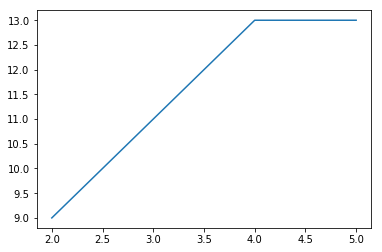

In [128]:
plt.plot(thresholds, vifs)
plt.show()

In [494]:
ccs = pd.read_csv('cross_correls_ethiopia_2015_v22.csv')
policy = ccs['Unnamed: 0'].apply(lambda x: x.find("___policy") != -1)
no_lives = ccs['Unnamed: 0'].apply(lambda x: x.find("lives_in") == -1)
no_lat = ccs['Unnamed: 0'].apply(lambda x: x.find("latitude") == -1)
no_dist = ccs['Unnamed: 0'].apply(lambda x: x.find("distance") == -1)
no_lon = ccs['Unnamed: 0'].apply(lambda x: x.find("longitude") == -1)
no_equ = ccs['Unnamed: 0'].apply(lambda x: x.find("equal") == -1)
ccs = ccs[no_lives & no_lat & no_lon & no_equ & no_dist]
cols = ccs.columns.values
best_var_series = {}
for output in cols:
    #output = 'average___ethiopia_2015'#'crop_sales___output___ethiopia_2015'#
    if output == 'Unnamed: 0':
        continue
    ccs[output] = ccs[output].apply(lambda x: abs(x))
    ccs = ccs.sort_values(output, ascending=False)
    best_vars = ccs[['Unnamed: 0', output]][:15].as_matrix()
#     best_vars = [i[0] for i in best_vars]
    best_var_series[output] = best_vars
best_var_series['crop_sales___output___ethiopia_2015']

array([['number_of_hired_workers___policy___ethiopia_2015',
        0.2738082677365537],
       ['land_surface___ethiopia_2015', 0.27251605259914585],
       ['average_precipitation___ethiopia_2015', 0.2294706219248923],
       ['quantity_of_chemical_fertilizers_used___policy___ethiopia_2015',
        0.16009055337326802],
       ['number_of_oxen_owned___policy___ethiopia_2015',
        0.15705349414011496],
       ['prevent_damage___policy___ethiopia_2015', 0.15313691644432134],
       ['gender_equity___policy___ethiopia_2015', 0.15266280975569105],
       ['elevation___ethiopia_2015', 0.1522841010209675],
       ['household_size___ethiopia_2015', 0.14258227392332665],
       ['number_of_plough_owned___policy___ethiopia_2015',
        0.14223988258113285],
       ['uses_extension_program___policy___ethiopia_2015',
        0.12981246190952828],
       ['household_head_is_male___ethiopia_2015', 0.12555273470354533],
       ['average_temperature___ethiopia_2015', 0.12206105019205225],
  

In [158]:
df_all = df


In [4]:
import pandas as pd
df = pd.read_csv('/home/ananth/Downloads/ethiopia_v23_normed.csv')
df.describe()
# df = df.loc[df['crop_sales___output___norm___ethiopia_2015'].dropna().index]
# r = np.mean(df)
# rdict = r.to_dict()
# rdict['land_surface___norm___ethiopia_2015']


,Unnamed: 0,children_education___output___ethiopia_2011,crop_sales___output___ethiopia_2011,expenditure___output___ethiopia_2011,food_expenditure_diversification___output___ethiopia_2011,has_medical_assistance___output___ethiopia_2011,no_food_deficiency___output___ethiopia_2011,productivity___output___ethiopia_2011,amount_of_assistance_received___policy___ethiopia_2011,crop_diversification___policy___ethiopia_2011,...,longitude___ethiopia_2015,number_of_droughts___ethiopia_2015,rooting_conditions_:_mainly_non-soil___ethiopia_2015,rooting_conditions_:_moderate_constraint___ethiopia_2015,rooting_conditions_:_no_or_slight_constraint___ethiopia_2015,rooting_conditions_:_severe_constraint___ethiopia_2015,rooting_conditions_:_very_severe_constraint___ethiopia_2015,rural_household___ethiopia_2015,variations_in_greenness___ethiopia_2015,weight___ethiopia_2015
count,3639.000000,2549.000000,1779.000000,3639.000000,3476.000000,3612.000000,3601.000000,1731.000000,3606.000000,2702.000000,...,3639.000000,3639.000000,3639.000000,3639.000000,3639.000000,3639.000000,3639.000000,3639.000000,3639.000000,3639.000000
mean,1819.000000,0.656267,6.239407,6.658564,0.664381,0.266112,0.714524,-2.744503,0.333306,2.556995,...,38.454400,0.254937,0.043419,0.154713,0.501786,0.156362,0.142622,0.885408,43.302830,4319.752745
std,1050.633142,0.366369,1.526063,1.514439,0.254461,0.322030,0.451704,1.761184,1.405252,2.883183,...,2.034458,0.441705,0.203825,0.361680,0.500066,0.363248,0.349735,0.318573,12.656131,4187.333902
min,0.000000,0.000000,0.406284,0.000000,0.000000,0.000000,0.000000,-8.616763,0.000000,0.000000,...,33.468357,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,6.844484
25%,909.500000,0.500000,5.273818,6.171991,0.532509,0.000000,0.000000,-3.885991,0.000000,0.000000,...,37.144541,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,36.000000,1225.015137
50%,1819.000000,0.750000,6.292388,6.904063,0.750000,0.166667,1.000000,-2.772643,0.000000,2.000000,...,38.311341,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,44.000000,3269.653564
75%,2728.500000,1.000000,7.250832,7.524839,0.859984,0.428571,1.000000,-1.652558,0.000000,4.000000,...,39.650890,0.693147,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,51.000000,6107.384277
max,3638.000000,1.000000,10.684777,13.337703,1.000000,1.000000,1.000000,4.189095,10.204448,16.000000,...,43.870658,2.944439,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,68.000000,32753.236328


In [532]:
imp_df
locations = ['afar', 'amhara', 'benishangul_gumuz', 'dire_dawa', 'gambella', 'harari', 'oromiya', 'snnp', 'somalie', 'tigray']
imp_df = imp_df.loc[imp_df[output].dropna().index]
for l in sorted(locations):
    loc_feature = 'lives_in_' + l + '___ethiopia_' + str(2015)
    df_loc = imp_df.loc[imp_df[loc_feature]==1]
    output = 'crop_sales___output___ethiopia_2015'  
    print (l, sum(df_loc['weight___ethiopia_2015'])/sum(imp_df['weight___ethiopia_2015'])*100.0, np.average(df_loc[output], weights=df_loc['weight___ethiopia_2015']))

afar 0.0398055198279 2129.3261381
amhara 25.8150368658 1155.75359963
benishangul_gumuz 1.59543145271 2725.0879217
dire_dawa 0.174135908025 1150.03649518
gambella 0.31624091125 2110.87379671
harari 0.180543438023 8034.89341087
oromiya 41.046503324 1767.39513676
snnp 26.6685963573 1036.59091902
somalie 0.409996338586 1545.2165131
tigray 3.75370988447 1898.11291005


In [601]:
np.percentile(imp_df['crop_sales___output___ethiopia_2015'].dropna(), [25,50,75])
np.std(imp_df['crop_sales___output___ethiopia_2015'].dropna())
from scipy.stats import percentileofscore
x = [568.191517737871, 245.304134630863, 902.739225809435]
for i in x:
    print(percentileofscore(df[output + '_change_value' + year].dropna(), i))
np.percentile(df[output + '_change_value' + year].dropna(), 75)

76.4168190128
67.0932358318
82.449725777


489.09268211400331

In [214]:
outputs = ['segment_children_education___output',
           'segment_crop_sales___output',
           'segment_crop_sales_growth___output',
           'segment_expenditure___output',
           'segment_food_expenditure_diversification___output']

# all_coef = pd.read_excel('./Tables_fixed_diversification/'+'coef_ethiopia.xlsx')

df = df_all
def for_year(var, year):
    return var + '___ethiopia_' + str(year)


imp_feats = select_all_year_feats()
# ['use_extension_program___policy',
#     'prevent_damage___policy',
#     'hired_labor___policy', 
#     'oxen_owned___policy', 
#     'chemical_fertilizers_used___policy']
series = pd.DataFrame()
for imp_feat in imp_feats:
    for output in ['segment_crop_sales___output']:
        years = ['2011', '2013', '2015']
#         years =['2013', '2015']
        raw_output = 'crop_sales___output'
        coef= {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1}
        for [y1, y2] in [['2011', '2013'], ['2013', '2015']]:
            #try:
            z1 = for_year(output, y1)
            z2 = for_year(output, y2)
            r1 = for_year(raw_output, y1)
            r2 = for_year(raw_output, y2)
            f1 = for_year(imp_feat,y1)
            f2 = for_year(imp_feat,y2)
            df[output + '_change' + y1] = (df[z1]!=df[z2])
            df[output + '_increase' + y1] = (df[z1]<df[z2])
            df[output + '_decrease' + y1] = (df[z1]>df[z2])
            expected = df[z1].apply(lambda x: coef[x])
            df[imp_feat+'_increase'+y1] = (imp_df[f2]-imp_df[f1])
            df[output + '_inversion' + y1] = (df[z2]-df[z1])*(df[f2]-df[f1])*expected
            df[output + '_change_value' + y1] = (imp_df[r2]-imp_df[r1])
            

    # for output in ['segment_crop_sales___output']:
    #     imp_feat = {'2011': 'distance_to_market___policy', '2013': 'prevent_damage___policy', '2015': 'hired_labor___policy'} 
    #     #imp_feat = {'2011': 'chemical_fertilizers_used___policy', '2013': 'chemical_fertilizers_used___policy', '2015': 'damaged_crop___policy'} 
    #     coef = {'2011': -0.168, '2013':+0.184, '2015': +0.182}
    #     segment = 'hired_labor___policy'
    #     df[output + '_change'] = False
    #     from itertools import combinations
    #     years = ['2011', '2013', '2015']
    #     for y in years:
    #         y_segment = for_year(segment, y)
    #         df = df.loc[df[y_segment].dropna().index]
    #         median_s = np.median(df[y_segment])
    #         df['cluster'+y] = [int(x) for x in df[y_segment] > median_s]
    #     df = df[df['cluster2011']==0]
    #     for [y1, y2] in combinations(years, 2):
    #         #try:
    #         z1 = for_year(output, y1)
    #         z2 = for_year(output, y2)
    #         f1 = for_year(imp_feat[y1],y1)
    #         f2 = for_year(imp_feat[y2],y2)
    #         df[output + '_change' + y1] = ((df[z1]!=df[z2]) & (df[z1]!=6) & (df[z2]!=6))
    #         df[output + '_inversion' + y1] = (df[z2]-df[z1])*(df[f2]-df[f1])*coef[y1]
    # #         except:
    # #             continue
    #         year = y1
        
        thresholds = {'2011': {0: 582.074037761, 1: 932.333779703, 2: 585.830244031, 3: 1026.46232607},
                      '2013': {0: 466.006285787, 1: 539.93544304, 2: 350.635222524, 3: 830.09513343}}
#         thresholds = [489.1]*4
#         df = df[df[output].dropna().index]
        for per in [0]:#[0, 5,10,15,20,25,30,35,40,45,50,55,60,70,75,80,85,90,95]:
            for seg in range(4):
                exp_y_i = []
                exp_y = []
                exp = []
                exp_i = []
                avg_y_i = []
                avg_y = []
                std_y_i = []
                std_y = []
                
                for [y1, y2] in [['2011', '2013'], ['2013', '2015']]:
                    dec_y = []
                    num_dec_y = []
                    dec_base_y = []
                    year = y1
                    weight = for_year('weight', year)
    #                 thres = thresholds[year][seg]
                    seg_y = for_year(output, year)
                    df_seg = df[df[seg_y]==seg]
                    df_seg = df_seg.loc[df_seg[output + '_change_value' + year].dropna().index]
#                     thres = np.percentile(df_seg[output + '_change_value' + year].dropna(), per)
    # #                 print (min(df_seg[output + '_change_value' + year].abs()))
    #                 df_x = df_seg[(df_seg[output + '_change'+year]==True)]
    #                 x = len(df_x)
    # #                 y = len(df[(df[seg_y]==seg)])
    #                 z = len(df.loc[df[output + '_change_value' + year].dropna().index])
    #                 y = len(df_seg)
#                     high_df = df_seg[df_seg[output + '_change_value' + year].apply(lambda x : x >= thres)]
    #                 high_change = len(high_df)
    #                 incr = len(df[(df[seg_y]==seg) & (df[output + '_increase'+year]==True) & (df[output + '_change_value' + year] > thres)])
    #                 decr = len(df[(df[seg_y]==seg) & (df[output + '_decrease'+year]==True) & (df[output + '_change_value' + year] < -1.0*thres)])
    #     #           print(df_x['segment_crop_sales___output_inversion'+year])
    #                 c_mean = np.mean(df_seg[output + '_change_value' + year].as_matrix())
    #                 c_stddev = np.std(df_seg[output + '_change_value' + year].as_matrix())
    #                 a = len(high_df[(high_df[output + '_inversion'+year]>=0)])
    #                 b = len(high_df[(high_df[output + '_inversion'+year]<0)])
    
#                     high_df = df_seg[(df_seg[imp_feat + '_increase'+year]>0)]
                    high_df = df_seg
                    std_dev = np.std(high_df[imp_feat + '_increase'+year])
                    feat_mean = np.mean(high_df[imp_feat + '_increase'+year])
                    def get_thresholds(v):
                        if v < -std_dev:
                            return 0
                        elif v < 0:
                            return 1
                        elif v > std_dev:
                            return 3
                        elif v >= 0:
                            return 2
                    
                    median = np.median(high_df[imp_feat + '_increase'+year].dropna())
                    print (imp_feat, median, year)
                    def get_simple_thresholds(v):
                        if v < median:
                            return 0
                        elif v == median:
                            return 1
                        elif v > median:
                            return 2
                        else:
                            return -1
                
                    high_df[imp_feat + '_decile'+year] = high_df[imp_feat + '_increase'+year].apply(lambda x: get_simple_thresholds(x))
#                     high_df[imp_feat + '_decile'+year] = pd.cut(high_df[imp_feat + '_increase'+year], 4, labels=False) #, duplicates='drop')
                    clus_avg = np.mean(df_seg[output + '_change_value' + year])
                    dec_base_y = clus_avg
                    for t in range(3):
                        num_dec_y.append(len(high_df[high_df[imp_feat + '_decile'+year]==t]))
                        dec_y.append(np.mean(high_df[high_df[imp_feat + '_decile'+year]==t][output + '_change_value' + year])/clus_avg)
                    exp_y_i.append(len(high_df[(high_df[imp_feat + '_increase'+year]>0)]))
                    exp_y.append(len(high_df))
                    exp = len(df_seg)
                    exp_i.append(len(df_seg[df_seg[imp_feat + '_increase'+year]>0]))
                    avg_y_i.append(np.mean(high_df[(high_df[imp_feat + '_increase'+year]>0)][output + '_change_value' + year]))
                    avg_y.append(np.mean(high_df[output + '_change_value' + year].dropna()))
                    std_y_i.append(np.std(high_df[(high_df[imp_feat + '_increase'+year]>0)][output + '_change_value' + year]))
                    std_y.append(np.std(high_df[output + '_change_value' + year].dropna()))
                    avg = np.median(df[output + '_change_value' + year].dropna())
                    row = {}
#                     row['threshold'] = per
                    row['input'] = imp_feat
                    row['from'] = year
                    row['to'] = y2
                    row['cluster #'] = seg
    #                 row['movement overall'] = (sum(exp_y)/sum(exp))*100.0
    #                 row['movement conditioned'] = (sum(exp_y_i)/sum(exp_i))*100.0
    #                 row['movement lift'] = (sum(exp_y_i)/sum(exp_i))/(sum(exp_y)/sum(exp))
                    row['num_hh_in_cluster'] = exp
    #                 row['num_hh_with_increase_in_input'] = sum(exp_i)
                    row['num_hh_in_bins'] = str(num_dec_y)
                    row['binned_conditional_lift_ratios'] = str(dec_y) 
                    row['average_change_in_output'] = dec_base_y
                
#                 row['conditional_ratio_of_averages'] = np.mean([j/k for j, k in zip(avg_y_i, avg_y)])
#                 row['population_average_change'] = str(avg_y)
#                 row['conditional_average_change'] = str(avg_y_i)
#                 row['population_std_change'] = str(std_y)
#                 row['conditional_std_change'] = str(std_y_i)
#                 row['raw lift'] = avg_y_i/avg_y
                    new_row = pd.DataFrame(row, index=[0])
                    series = series.append(new_row, ignore_index=True)

series.to_csv('./threshold-lift-simple.csv')
    #                 print (year, seg, np.percentile(df_seg[output + '_change_value' + year].dropna(), 75))
    #                 _i = np.mean(df_seg[df_seg[imp_feat + '_increase'+year]==True][output + '_change_value' + year])
    #                 print (imp_feat, year, y2, seg, (a/(a+b))*100.0, x/y*100.0, high_change/y*100.0, incr/y*100.0, decr/y*100.0, y/z*100.0, y, x, a, c_mean, c_stddev)
#                     print (per, imp_feat, year, y2, seg, exp_i, (exp_y/exp)*100.0, (exp_y_i/exp_i)*100.0, (exp_y_i/exp_i)/(exp_y/exp), avg_y_i/avg_y) 
                
#                 seg_y = for_year(output, year)
#                 df_x = imp_df[(df[seg_y]==seg) & (df[output + '_change'+year]==True)]
#                 incr = sum(imp_df[(df[seg_y]==seg) & (df[output + '_increase'+year]==True)][weight])
#                 decr = sum(imp_df[(df[seg_y]==seg) & (df[output + '_decrease'+year]==True)][weight])
#                 x = sum(df_x[weight])
#                 y = sum(imp_df[(df[seg_y]==seg)][weight])
#                 z = sum(imp_df[weight])
#                 df_seg = df[df[seg_y]==seg]
#                 df_seg = df_seg.loc[df_seg[output + '_change_value' + year].dropna().index]
#                 imp_seg = imp_df.loc[df[df[seg_y]==seg][output + '_change_value' + year].dropna().index]
#     #             print(df_x['segment_crop_sales___output_inversion'+year])
#                 thres = 1.0
#                 high_change = len(df_seg[output + '_change_value' + year].abs().apply(lambda x : x > thres))
#                 values = df_seg[output + '_change_value' + year].as_matrix()
#                 c_mean = np.average(values, weights=imp_seg[weight])
#                 average = c_mean
#                 variance = np.average((values-average)**2, weights=imp_seg[weight])
#                 c_stddev = math.sqrt(variance)/math.sqrt(len(values))
#                 a = sum(imp_df[(df[seg_y]==seg) & (df[output + '_change'+year]==True) & (df[output + '_inversion'+year]>=0)][weight])
#                 b = sum(imp_df[(df[seg_y]==seg) & (df[output + '_change'+year]==True) & (df[output + '_inversion'+year]<0)][weight])
#                 print (imp_feat, year, y2, seg, (a/(a+b))*100.0, x/y*100.0, high_change/y*100.0, incr/y*100.0, decr/y*100.0, y/z*100.0, c_mean, c_stddev)

# df['any_change']= False
# for output in outputs:
#     df['any_change'] |= (df[output+'_change']==True)


# a = len(df[(df['segment_crop_sales___output_change2011']==True) & (df['segment_crop_sales___output_inversion2011']>=0)])
# b = len(df[(df['segment_crop_sales___output_change2011']==True) & (df['segment_crop_sales___output_inversion2011']<0)])
# c = len(df[(df['segment_crop_sales___output_change2013']==True) & (df['segment_crop_sales___output_inversion2013']>=0)])
# d = len(df[(df['segment_crop_sales___outavg_yput_change2013']==True) & (df['segment_crop_sales___output_inversion2013']<0)])
# [a/(a+b), c/(c+d)]

quantity_of_improved_seeds_used___policy 0.0 2011
quantity_of_improved_seeds_used___policy 0.0 2013
quantity_of_improved_seeds_used___policy 0.0 2011
quantity_of_improved_seeds_used___policy 0.0 2013
quantity_of_improved_seeds_used___policy 0.0 2011
quantity_of_improved_seeds_used___policy 0.0 2013
quantity_of_improved_seeds_used___policy 0.0 2011
quantity_of_improved_seeds_used___policy 0.0 2013
price_rise_of_food_item___policy 0.0 2011
price_rise_of_food_item___policy 0.0 2013
price_rise_of_food_item___policy 0.0 2011
price_rise_of_food_item___policy 0.0 2013
price_rise_of_food_item___policy 0.0 2011
price_rise_of_food_item___policy 0.0 2013
price_rise_of_food_item___policy 0.0 2011
price_rise_of_food_item___policy 0.0 2013
owns_land_certificate___policy 0.0 2011
owns_land_certificate___policy 0.0 2013
owns_land_certificate___policy 0.0 2011
owns_land_certificate___policy 0.0 2013
owns_land_certificate___policy 0.0 2011
owns_land_certificate___policy 0.0 2013
owns_land_certificate___

In [284]:
for i in range(7):
    print(len(df[df['segment_crop_sales___output___ethiopia_2011'] == i])/len(df)*100.0)

0.0
0.7433489827856025
8.450704225352112
29.42097026604069
24.49139280125196
3.7167449139280127
33.17683881064163


In [305]:
1-len(df[df['cluster2011']==0])/len(df_all)

0.596042868920033

In [281]:
2372/(2372+184)

0.9280125195618153

In [167]:
df


Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            3628, 3629, 3630, 3631, 3632, 3633, 3635, 3636, 3637, 3638],
           dtype='int64', length=3608)

In [ ]:
t_1_2011 = a/(a+b)
t_1_2013 = c/(c+d)

ZeroDivisionError: division by zero